In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 23 13:50:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

170508288/170498071 [==============================] - 4s 0us/step


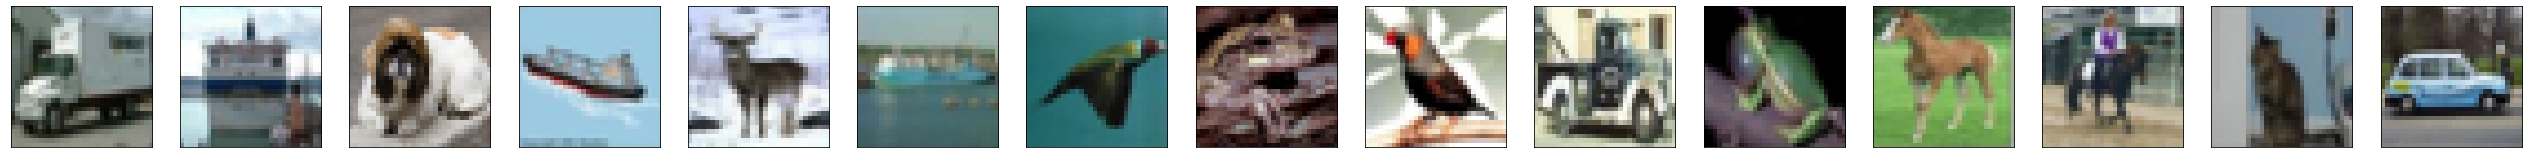

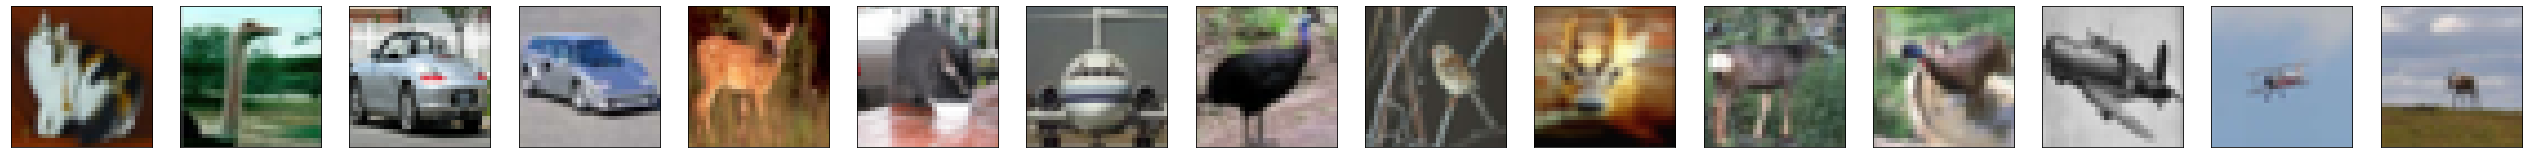

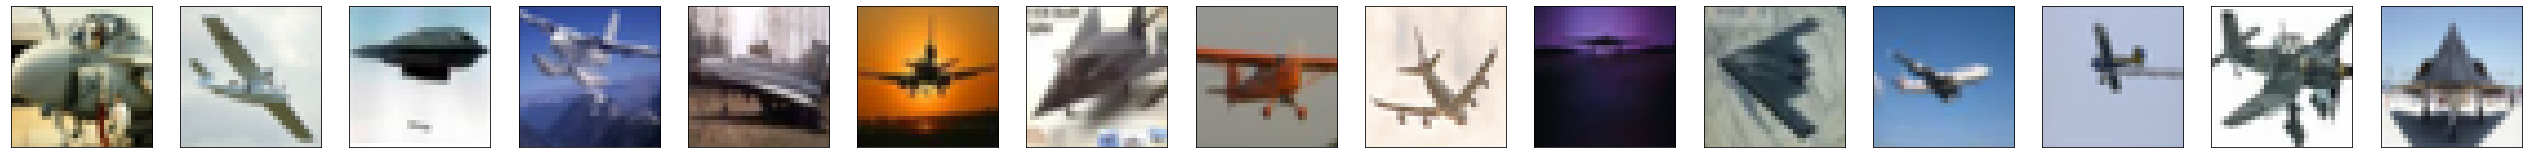

In [ ]:
import tensorflow as tf
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt

import FSHA
import architectures
import datasets
from datasets import *

#load cifar10 dataset
cpriv, cpub = load_cifar()
cpriv5, cpub5 = load_cifar_5()

n = 15
c_priv = datasets.getImagesDS(cpriv, n)
c_pub5 = datasets.getImagesDS(cpub5, n)

datasets.plot(c_priv)
datasets.plot(c_pub5)

cpub10 = load_cifar_test_10()
n = 15
c_test0 = datasets.getImagesDS(cpub10[0], n)
datasets.plot(c_test0)

# training hparams
batch_size = 640
id_setup = 4
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'w' : 1,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}
log_frequency = 100

def get_cos_sim(v1, v2):
  num = float(np.dot(v1,v2))
  denom = np.linalg.norm(v1) * np.linalg.norm(v2)
  return 0.5 + 0.5 * (num / denom) if denom != 0 else 0

def plot_gradient(fsha_model, sl_model, dataset, itr):
  dif_category_fsha = []
  con_image_fsha = []
  same_category_fsha = []
  dif_category_sl = []
  con_image_sl = []
  same_category_sl = []

  for k in range(10):
    c_set = list(dataset)
    c1 = []
    c2 = []
    c3 = []
    c1_x = []
    c2_x = []
    c3_x = []
    c4_x = []
    c1_y = []
    c2_y = []
    c3_y = []
    c4_y = []
    for j in range(2000):
      if len(c1) < 64:
        if c_set[j][1].numpy() == np.array(k):
          c1_x.append(c_set[j][0])
          c1_y.append(c_set[j][1])
          c1.append(j)
          e = c_set[j][0].numpy()
          e = -e
          c4 = tf.convert_to_tensor(e, dtype=tf.float32)
          c4_x.append(c4)
          c4_y.append([(k+2)%10])
      elif len(c3) < 64:
        if c_set[j][1].numpy() == np.array(k):
          c3_x.append(c_set[j][0])
          c3_y.append(c_set[j][1])
          c3.append(j)
      if len(c2) < 64:
        if c_set[j][1].numpy() == np.array((k+1)%10):
          c2_x.append(c_set[j][0])
          c2_y.append(c_set[j][1])
          c2.append(j)
    

    c1_x = tf.stack(c1_x, axis = 0)
    c2_x = tf.stack(c2_x, axis = 0)
    c3_x = tf.stack(c3_x, axis = 0)
    c4_x = tf.stack(c4_x, axis = 0)

    gp1 = fsha_model.get_gradient(c1_x, c1_y).numpy()
    gp2 = fsha_model.get_gradient(c2_x, c2_y).numpy()
    gp3 = fsha_model.get_gradient(c3_x, c3_y).numpy()
    gp4 = fsha_model.get_gradient(c4_x, c4_y).numpy()
    gf1 = sl_model.get_gradient(c1_x, c1_y).numpy()
    gf2 = sl_model.get_gradient(c2_x, c2_y).numpy()
    gf3 = sl_model.get_gradient(c3_x, c3_y).numpy()
    gf4 = sl_model.get_gradient(c4_x, c4_y).numpy()

    dif_category_4k_fsha = []
    con_image_4k_fsha = []
    same_category_4k_fsha = []
    dif_category_4k_sl = []
    con_image_4k_sl = []
    same_category_4k_sl = []
    for i in range(64):
      p1 = gp1[i].reshape(4096,)
      p2 = gp2[i].reshape(4096,)
      p3 = gp3[i].reshape(4096,)
      p4 = gp4[i].reshape(4096,)
      f1 = gf1[i].reshape(4096,)
      f2 = gf2[i].reshape(4096,)
      f3 = gf3[i].reshape(4096,)
      f4 = gf4[i].reshape(4096,)
      dif_category_4k_fsha.append(get_cos_sim(p1,p2))
      dif_category_4k_sl.append(get_cos_sim(f1,f2))
      con_image_4k_fsha.append(get_cos_sim(p1,p4))
      con_image_4k_sl.append(get_cos_sim(f1,f4))
      same_category_4k_fsha.append(get_cos_sim(p1,p3))
      same_category_4k_sl.append(get_cos_sim(f1,f3))
      dif_category_fsha.append(get_cos_sim(p1,p2))
      dif_category_sl.append(get_cos_sim(f1,f2))
      con_image_fsha.append(get_cos_sim(p1,p4))
      con_image_sl.append(get_cos_sim(f1,f4))
      same_category_fsha.append(get_cos_sim(p1,p3))
      same_category_sl.append(get_cos_sim(f1,f3))

    dif_category_4k_fsha = np.array(dif_category_4k_fsha)
    con_image_4k_fsha = np.array(con_image_4k_fsha)
    same_category_4k_fsha = np.array(same_category_4k_fsha)
    dif_category_4k_sl = np.array(dif_category_4k_sl)
    con_image_4k_sl = np.array(con_image_4k_sl)
    same_category_4k_sl = np.array(same_category_4k_sl)
    print("category: ", k)
    print(np.mean(dif_category_4k_fsha), np.mean(dif_category_4k_sl))
    print(np.mean(con_image_4k_fsha), np.mean(con_image_4k_sl))
    print(np.mean(same_category_4k_fsha), np.mean(same_category_4k_sl))
    fsha_4k = [np.mean(dif_category_4k_fsha), np.mean(con_image_4k_fsha), np.mean(same_category_4k_fsha)]
    sl_4k = [np.mean(dif_category_4k_sl), np.mean(con_image_4k_sl), np.mean(same_category_4k_sl)]
    fsha_std_4k = [np.std(dif_category_4k_fsha), np.std(con_image_4k_fsha), np.std(same_category_4k_fsha)]
    sl_std_4k = [np.std(dif_category_4k_sl), np.std(con_image_4k_sl), np.std(same_category_4k_sl)]
    x = np.arange(3)
    error_attri={"elinewidth":2,"ecolor":"black","capsize":6}
    bar_width=0.4
    tick_label=['dif category','con_sample','same category']
    plt.bar(x,fsha_4k,bar_width, color="#87cee3",align="center",yerr=fsha_std_4k,error_kw=error_attri,label='abnormal',alpha=1)
    plt.bar(x+bar_width,sl_4k,bar_width,color="#cd5c5c",yerr=sl_std_4k,error_kw=error_attri,label='normal',alpha=1)
    plt.xlabel('')
    plt.ylabel("cosine similarity")
    plt.xticks(x+bar_width/2, tick_label)
    plt.title("%d iteration" % (itr))
    plt.grid(axis="y",ls="-",color="purple",alpha=0.7)
    plt.legend()
    plt.show()
  
  print("==================================================")
  print("average gradient: ")
  dif_category_4k_fsha = np.array(dif_category_fsha)
  con_image_4k_fsha = np.array(con_image_fsha)
  same_category_4k_fsha = np.array(same_category_fsha)
  dif_category_4k_sl = np.array(dif_category_sl)
  con_image_4k_sl = np.array(con_image_sl)
  same_category_4k_sl = np.array(same_category_sl)
  print("category: ", k)
  print(np.mean(dif_category_4k_fsha), np.mean(dif_category_4k_sl))
  print(np.mean(con_image_4k_fsha), np.mean(con_image_4k_sl))
  print(np.mean(same_category_4k_fsha), np.mean(same_category_4k_sl))
  fsha_4k = [np.mean(dif_category_4k_fsha), np.mean(con_image_4k_fsha), np.mean(same_category_4k_fsha)]
  sl_4k = [np.mean(dif_category_4k_sl), np.mean(con_image_4k_sl), np.mean(same_category_4k_sl)]
  fsha_std_4k = [np.std(dif_category_4k_fsha), np.std(con_image_4k_fsha), np.std(same_category_4k_fsha)]
  sl_std_4k = [np.std(dif_category_4k_sl), np.std(con_image_4k_sl), np.std(same_category_4k_sl)]
  x = np.arange(3)
  error_attri={"elinewidth":2,"ecolor":"black","capsize":6}
  bar_width=0.4
  tick_label=['dif category','con_sample','same category']
  plt.bar(x,fsha_4k,bar_width, color="#87cee3",align="center",yerr=fsha_std_4k,error_kw=error_attri,label='abnormal',alpha=1)
  plt.bar(x+bar_width,sl_4k,bar_width,color="#cd5c5c",yerr=sl_std_4k,error_kw=error_attri,label='normal',alpha=1)
  plt.xlabel('')
  plt.ylabel("cosine similarity")
  plt.xticks(x+bar_width/2, tick_label)
  plt.title("%d iteration" % (itr))
  plt.grid(axis="y",ls="-",color="purple",alpha=0.7)
  plt.legend()
  plt.show()


Normal split learning model

In [ ]:
# Good server
import datasets, arch

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class SL_new:

    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_s = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            s_shape = self.f.output.shape.as_list()[1:]
            self.s = make_s(s_shape)

            # setup optimizers
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    def train_step(self, x_private, x_public, label_private, label_public):

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.s(z_private, training=True)
            f_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##

        # train network 
        var = self.f.trainable_variables + self.s.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer.apply_gradients(zip(gradients, var))

        return tf.reduce_mean(f_loss)


    def get_gradient(self, x_private, label_private):
        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.s(z_private, training=True)
            f_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))

        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)

        i, j = 0, 0
        print("RUNNING...")
        for (x_private, label_private), (x_public, label_public) in iterator:
            log = self.train_step(x_private, x_public, label_private, label_public)

            if i == 0:
                VAL = log                          
            else:
                VAL += log / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log

                if verbose:
                    print("log--%02d%%-%07d] loss: %0.4f" % ( int(i/iterations*100) ,i, VAL) )

                VAL = 0
                j += 1


            i += 1
        return LOG

Attack model (discriminater)

In [ ]:
def projection_layer(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Flatten()(xin)
    x = tf.keras.layers.Dense(128)(x)
    return tf.keras.Model(xin, x)

# UTT attack model
import tqdm
import datasets, architectures, arch

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class FSHA_worst:
    
    def loadBiasNetwork(self, make_decoder, z_shape, channels):
        return make_decoder(z_shape, channels=channels)
        
    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            # print("input shape: ", input_shape)
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_tilde_f, make_decoder, make_D = architectures.SETUPS[id_setup]
            _, make_S = arch.SETUPS[id_setup]
            _, classifier = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            self.tilde_f = make_tilde_f(input_shape)

            assert self.f.output.shape.as_list()[1:] == self.tilde_f.output.shape.as_list()[1:]
            z_shape = self.tilde_f.output.shape.as_list()[1:]
            print("feature shape: ", z_shape)
            self.D = make_D(z_shape)
            self.decoder = self.loadBiasNetwork(make_decoder, z_shape, channels=input_shape[-1])
            self.S = make_S(z_shape)
            self.c = classifier(z_shape)
            # print("output shape: ", self.S.output.shape.as_list()[1:])

            self.w = hparams['w']

            # setup optimizers
            self.optimizer0 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])
            self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])
            self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer3 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer4 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])

            # gradient
            self.gradient = ''



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    @tf.function
    def train_step(self, x_private, x_public, label_private, label_public, category_index):

        with tf.GradientTape(persistent=True) as tape:

            # print(label_private)

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)

            #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##
            
            # print(f_loss_1)
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                adv_private_logits1 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits2 = tf.reduce_sum(adv_private_logits1)
                f_loss = tf.reduce_max(adv_private_logits2)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True))
            ##

            z_public = self.tilde_f(x_public, training=True)
            public_logits = self.c(z_public, training=True)
            c_loss = tf.keras.losses.sparse_categorical_crossentropy(label_public, public_logits, from_logits=True)

            # invertibility loss
            rec_x_public = self.decoder(z_public, training=True)
            public_rec_loss = distance_data_loss(x_public, rec_x_public)
            tilde_f_loss = public_rec_loss


            # discriminator on attacker's feature-space
            adv_public_logits = self.D(z_public, training=True)
            if self.hparams['WGAN']:
                adv_public_logits1 = tf.matmul(category_index,adv_public_logits)
                adv_public_logits2 = tf.reduce_sum(adv_public_logits1)
                adv_private_logits3 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits4 = tf.reduce_sum(adv_private_logits1)
                # discriminator's loss
                D_loss = tf.reduce_max(adv_public_logits2-adv_private_logits4)
            else:
                loss_discr_true = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_public_logits), adv_public_logits, from_logits=True))
                loss_discr_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(adv_private_logits), adv_private_logits, from_logits=True))
                # discriminator's loss
                D_loss = (loss_discr_true + loss_discr_fake) / 2

            if 'gradient_penalty' in self.hparams:
                # print("Use GP")
                w = float(self.hparams['gradient_penalty'])
                D_gradient_penalty = self.gradient_penalty(z_private, z_public)
                D_loss += D_gradient_penalty * w

            ##################################################################
            ## attack validation #####################
            loss_c_verification = distance_data(x_private, rec_x_private)
            ############################################
            ##################################################################

        # train supervised autoencoder
        var = self.tilde_f.trainable_variables + self.c.trainable_variables
        gradients = tape.gradient(c_loss, var)
        self.optimizer4.apply_gradients(zip(gradients, var))

        # train substitute network 
        var = self.S.trainable_variables
        gradients = tape.gradient(sf_loss, var)
        self.optimizer3.apply_gradients(zip(gradients, var))


        # train client's network 
        var = self.f.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer0.apply_gradients(zip(gradients, var))
        

        # train attacker's autoencoder(decoder part) on public data
        var = self.decoder.trainable_variables
        gradients = tape.gradient(tilde_f_loss, var)
        self.optimizer1.apply_gradients(zip(gradients, var))

        # train discriminator
        var = self.D.trainable_variables
        gradients = tape.gradient(D_loss, var)
        self.optimizer2.apply_gradients(zip(gradients, var))


        return f_loss, tilde_f_loss, D_loss, loss_c_verification

    def get_gradient(self, x_private, label_private):
        category_index_n = []
        category_index = []
        category_number = []
        for n in range(10):
          category_index_n.append([0]*64)
          category_number.append(0)

        # public_data = random.shuffle(public_data)
        for index,l in enumerate(label_private):
          # print(np.array(l[0]))
          category = np.array(l[0])
          category_index_n[category][index] = 1
          category_number[category] += 1
        
        for n in range(10):
          if category_number[n] != 0:
            category_index_n[n] = [x/category_number[n] for x in category_index_n[n]]
          else:
            category_index_n[n] = [x for x in category_index_n[n]]

        category_index = tf.constant(category_index_n)

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=False)
            ####################################


            #### SERVER-SIDE:
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=False)
             #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##
            
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                adv_private_logits1 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits2 = tf.reduce_sum(adv_private_logits1)
                f_loss = tf.reduce_max(adv_private_logits2)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True)) + f_loss_1
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    
    @tf.function
    def score(self, x_private, label_private):
        z_private = self.f(x_private, training=False)
        tilde_x_private = self.decoder(z_private, training=False)
        
        err = tf.reduce_mean( distance_data(x_private, tilde_x_private))
        
        return err
    
    def scoreAttack(self, dataset):
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        scorelog = 0
        i = 0
        for x_private, label_private in tqdm.tqdm(dataset):
            scorelog += self.score(x_private, label_private).numpy()
            i += 1
             
        return scorelog / i

    def attack(self, x_private):
        # smashed data sent from the client:
        z_private = self.f(x_private, training=False)
        # recover private data from smashed data
        tilde_x_private = self.decoder(z_private, training=False)

        z_private_control = self.tilde_f(x_private, training=False)
        control = self.decoder(z_private_control, training=False)
        return tilde_x_private.numpy(), control.numpy()


    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))

        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)

        i, j = 0, 0
        print("RUNNING...")
        public_data = []
        for datalist in cpub10:
          # print(len(list(datalist)))
          public_data.append(list(datalist))
        
        # print(len(public_data))
        for (x_private, label_private), (_, _) in iterator:
            category_index_n = []
            category_index = []
            category_number = []
            for n in range(10):
              category_index_n.append([0]*self.batch_size)
              category_number.append(0)

            # public_data = random.shuffle(public_data)
            for index,l in enumerate(label_private):
              category = l.numpy()[0]
              category_index_n[category][index] = 1
              category_number[category] += 1
              # print(category)
              if index == 0:
                random.shuffle(public_data[category])
                # print(len(public_data[category]))
                x_public = tf.reshape(public_data[category][0][0], [1,32,32,3])
              else:
                random.shuffle(public_data[category])
                x_public = tf.concat([x_public, tf.reshape(public_data[category][0][0], [1,32,32,3])], axis=0)
            
            for n in range(10):
              if category_number[n] != 0:
                category_index_n[n] = [x/category_number[n] for x in category_index_n[n]]
              else:
                category_index_n[n] = [x for x in category_index_n[n]]

            category_index = tf.constant(category_index_n)

            log = self.train_step(x_private, x_public, label_private, label_private, category_index)

            if i == 0:
                VAL = log[3]                     
            else:
                VAL += log[3] / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log
                print(category_number)
                if verbose:
                    print("log--%02d%%-%07d] validation: %0.4f" % ( int(i/iterations*100) ,i, VAL))
                    # self.gradient = self.get_gradient(x_private, label_private)

                VAL = 0
                j += 1


            i += 1
        return LOG

In [ ]:
# UTT attack model
import tqdm
import datasets, architectures, arch

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class FSHA_worse:
    
    def loadBiasNetwork(self, make_decoder, z_shape, channels):
        return make_decoder(z_shape, channels=channels)
        
    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            # print("input shape: ", input_shape)
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_tilde_f, make_decoder, make_D = architectures.SETUPS[id_setup]
            _, make_S = arch.SETUPS[id_setup]
            _, classifier = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            self.tilde_f = make_tilde_f(input_shape)

            assert self.f.output.shape.as_list()[1:] == self.tilde_f.output.shape.as_list()[1:]
            z_shape = self.tilde_f.output.shape.as_list()[1:]
            print("feature shape: ", z_shape)
            self.D = make_D(z_shape)
            self.decoder = self.loadBiasNetwork(make_decoder, z_shape, channels=input_shape[-1])
            self.S = make_S(z_shape)
            # print("output shape: ", self.S.output.shape.as_list()[1:])

            self.w = hparams['w']

            # setup optimizers
            self.optimizer0 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])
            self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])
            self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer3 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer4 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])

            # gradient
            self.gradient = ''



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    @tf.function
    def train_step(self, x_private, x_public, label_private, label_public, category_index):

        with tf.GradientTape(persistent=True) as tape:

            # print(label_private)

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)

            #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##
            
            # print(f_loss_1)
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                adv_private_logits1 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits2 = tf.reduce_sum(adv_private_logits1)
                f_loss = tf.reduce_max(adv_private_logits2)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True))
            ##

            z_public = self.tilde_f(x_public, training=True)

            # invertibility loss
            rec_x_public = self.decoder(z_public, training=True)
            public_rec_loss = distance_data_loss(x_public, rec_x_public)
            tilde_f_loss = public_rec_loss


            # discriminator on attacker's feature-space
            adv_public_logits = self.D(z_public, training=True)
            if self.hparams['WGAN']:
                adv_public_logits1 = tf.matmul(category_index,adv_public_logits)
                adv_public_logits2 = tf.reduce_sum(adv_public_logits1)
                adv_private_logits3 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits4 = tf.reduce_sum(adv_private_logits1)
                # discriminator's loss
                D_loss = tf.reduce_max(adv_public_logits2-adv_private_logits4)
            else:
                loss_discr_true = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_public_logits), adv_public_logits, from_logits=True))
                loss_discr_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(adv_private_logits), adv_private_logits, from_logits=True))
                # discriminator's loss
                D_loss = (loss_discr_true + loss_discr_fake) / 2

            if 'gradient_penalty' in self.hparams:
                # print("Use GP")
                w = float(self.hparams['gradient_penalty'])
                D_gradient_penalty = self.gradient_penalty(z_private, z_public)
                D_loss += D_gradient_penalty * w

            ##################################################################
            ## attack validation #####################
            loss_c_verification = distance_data(x_private, rec_x_private)
            ############################################
            ##################################################################

        # train substitute network 
        var = self.S.trainable_variables
        gradients = tape.gradient(sf_loss, var)
        self.optimizer3.apply_gradients(zip(gradients, var))


        # train client's network 
        var = self.f.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer0.apply_gradients(zip(gradients, var))
        

        # train attacker's autoencoder(decoder part) on public data
        var = self.tilde_f.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(tilde_f_loss, var)
        self.optimizer1.apply_gradients(zip(gradients, var))

        # train discriminator
        var = self.D.trainable_variables
        gradients = tape.gradient(D_loss, var)
        self.optimizer2.apply_gradients(zip(gradients, var))


        return f_loss, tilde_f_loss, D_loss, loss_c_verification

    def get_gradient(self, x_private, label_private):
        category_index_n = []
        category_index = []
        category_number = []
        for n in range(10):
          category_index_n.append([0]*self.batch_size)
          category_number.append(0)

        # public_data = random.shuffle(public_data)
        for index,l in enumerate(label_private):
          # print(np.array(l[0]))
          category = np.array(l[0])
          category_index_n[category][index] = 1
          category_number[category] += 1
        
        for n in range(10):
          if category_number[n] != 0:
            category_index_n[n] = [x/category_number[n] for x in category_index_n[n]]
          else:
            category_index_n[n] = [x for x in category_index_n[n]]

        category_index = tf.constant(category_index_n)

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=False)
            ####################################


            #### SERVER-SIDE:
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=False)
             #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##
            
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                adv_private_logits1 = tf.matmul(category_index,adv_private_logits)
                adv_private_logits2 = tf.reduce_sum(adv_private_logits1)
                f_loss = tf.reduce_max(adv_private_logits2)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True)) + f_loss_1
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    
    @tf.function
    def score(self, x_private, label_private):
        z_private = self.f(x_private, training=False)
        tilde_x_private = self.decoder(z_private, training=False)
        
        err = tf.reduce_mean( distance_data(x_private, tilde_x_private))
        
        return err
    
    def scoreAttack(self, dataset):
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        scorelog = 0
        i = 0
        for x_private, label_private in tqdm.tqdm(dataset):
            scorelog += self.score(x_private, label_private).numpy()
            i += 1
             
        return scorelog / i

    def attack(self, x_private):
        # smashed data sent from the client:
        z_private = self.f(x_private, training=False)
        # recover private data from smashed data
        tilde_x_private = self.decoder(z_private, training=False)

        z_private_control = self.tilde_f(x_private, training=False)
        control = self.decoder(z_private_control, training=False)
        return tilde_x_private.numpy(), control.numpy()


    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))

        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)

        i, j = 0, 0
        print("RUNNING...")
        public_data = []
        for datalist in cpub10:
          # print(len(list(datalist)))
          public_data.append(list(datalist))
        
        # print(len(public_data))
        for (x_private, label_private), (_, _) in iterator:
            category_index_n = []
            category_index = []
            category_number = []
            for n in range(10):
              category_index_n.append([0]*self.batch_size)
              category_number.append(0)

            # public_data = random.shuffle(public_data)
            for index,l in enumerate(label_private):
              category = l.numpy()[0]
              category_index_n[category][index] = 1
              category_number[category] += 1
              # print(category)
              if index == 0:
                random.shuffle(public_data[category])
                # print(len(public_data[category]))
                x_public = tf.reshape(public_data[category][0][0], [1,32,32,3])
              else:
                random.shuffle(public_data[category])
                x_public = tf.concat([x_public, tf.reshape(public_data[category][0][0], [1,32,32,3])], axis=0)
            
            for n in range(10):
              if category_number[n] != 0:
                category_index_n[n] = [x/category_number[n] for x in category_index_n[n]]
              else:
                category_index_n[n] = [x for x in category_index_n[n]]

            category_index = tf.constant(category_index_n)

            log = self.train_step(x_private, x_public, label_private, label_private, category_index)

            if i == 0:
                VAL = log[3]                     
            else:
                VAL += log[3] / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log
                print(category_number)
                if verbose:
                    print("log--%02d%%-%07d] validation: %0.4f" % ( int(i/iterations*100) ,i, VAL))
                    # self.gradient = self.get_gradient(x_private, label_private)

                VAL = 0
                j += 1


            i += 1
        return LOG

In [ ]:
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'w' : 10,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}
fshawd1 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
fshawd2 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 200
LOG = fshawd1(3000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOG = fshawd2(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
[3, 5, 10, 7, 4, 11, 7, 3, 8, 6]
log--00%-0000000] validation: 0.2986
[9, 10, 7, 10, 8, 3, 6, 2, 6, 3]
log--06%-0000200] validation: 0.2655
[7, 11, 5, 9, 4, 3, 4, 6, 5, 10]
log--13%-0000400] validation: 0.2628
[5, 10, 7, 7, 11, 8, 5, 4, 2, 5]
log--20%-0000600] validation: 0.2617
[4, 4, 5, 11, 3, 7, 9, 7, 8, 6]
log--26%-0000800] validation: 0.2591
[13, 8, 6, 7, 8, 6, 5, 6, 3, 2]
log--33%-0001000] validation: 0.2579
[8, 4, 8, 7, 7, 8, 9, 4, 6, 3]
log--40%-0001200] validation: 0.2580
[8, 7, 6, 6, 10, 6, 5, 5, 7, 4]
log--46%-0001400] validation: 0.2572
[7, 8, 8, 10, 3, 7, 5, 3, 5, 8]
log--53%-0001600] validation: 0.2539
[4, 4, 7, 6, 9, 9, 7, 4, 7, 7]
log--60%-0001800] validation: 0.2581
[9, 9, 3, 8, 4, 7, 6, 5, 6, 7]
log--66%-0002000] validation: 0.2567
[10, 6, 5, 6, 6, 6, 10, 6, 2, 7]
log--73%-0002200] validation: 0.

In [ ]:
slw1 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
slw2 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
LOGs = slw1(3000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOGs = slw2(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
log--00%-0000000] loss: 3.0572
log--06%-0000200] loss: 1.9382
log--13%-0000400] loss: 1.6227
log--20%-0000600] loss: 1.5247
log--26%-0000800] loss: 1.4438
log--33%-0001000] loss: 1.3122
log--40%-0001200] loss: 1.2858
log--46%-0001400] loss: 1.2499
log--53%-0001600] loss: 1.1987
log--60%-0001800] loss: 1.1278
log--66%-0002000] loss: 1.1091
log--73%-0002200] loss: 1.0907
log--80%-0002400] loss: 1.0486
log--86%-0002600] loss: 0.9931
log--93%-0002800] loss: 0.9755
RUNNING...
log--00%-0000000] loss: 2.9023
log--02%-0000200] loss: 1.9317
log--04%-0000400] loss: 1.6040
log--06%-0000600] loss: 1.4909
log--08%-0000800] loss: 1.4145
log--10%-0001000] loss: 1.3089
log--12%-0001200] loss: 1.2620
log--14%-0001400] loss: 1.2322
log--16%-0001600] loss: 1.1890
log--18%-0001800] loss: 1.1346
log--20%-0002000] loss: 1.1059
log--22%-0002200] loss: 1.0805
log--24%-0002400] loss: 1.0259
log--26%-0002600] loss: 0.9867
log--28%-0002800] loss: 0.9969
log--30%-0003000] loss: 0.9540
log--32%-0003200]

category:  0
0.5780360442473981 0.5005829699280593
0.3259087003625988 0.4348755628679286
0.6182104348874153 0.7556371685626948


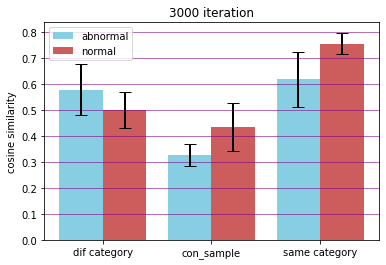

category:  1
0.5899934275712362 0.45662891591231625
0.3130817086946735 0.44313078108014825
0.626866874943047 0.7824970502521384


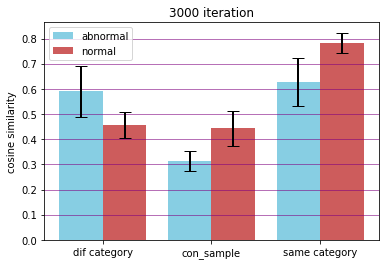

category:  2
0.5987051360421675 0.4549744608689624
0.3424187384194573 0.45528246470760325
0.5992209545123661 0.7434215295048323


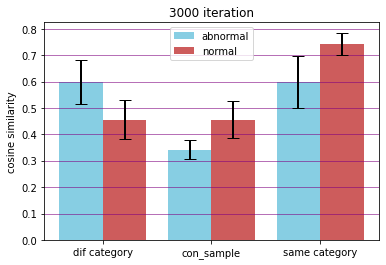

category:  3
0.5800127686305596 0.464669010210086
0.31639758771019943 0.44686241726021547
0.5840007422235456 0.7367115899130203


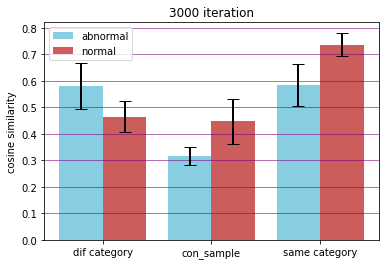

category:  4
0.6344113352864336 0.4661057092885823
0.33559796456212493 0.5113582280202285
0.6126601947864767 0.756451302938342


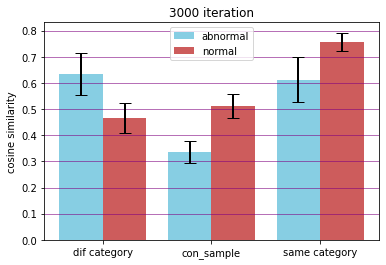

category:  5
0.603000737836366 0.4904490029472587
0.3222851747602348 0.4470473050308615
0.5943378604099284 0.750880169321635


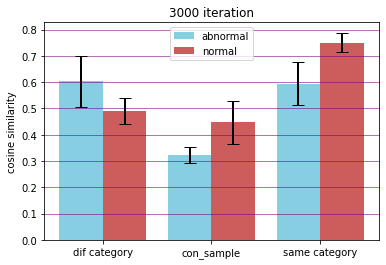

category:  6
0.5970717585895859 0.4894974844283919
0.3487022694058711 0.4646419880852035
0.6112141312088174 0.7704170853580196


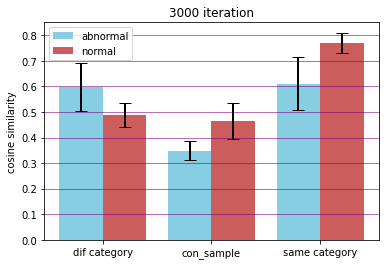

category:  7
0.5910821997098248 0.43925780947682347
0.32802450604157374 0.5250221677055211
0.6000424896523271 0.7796802634684087


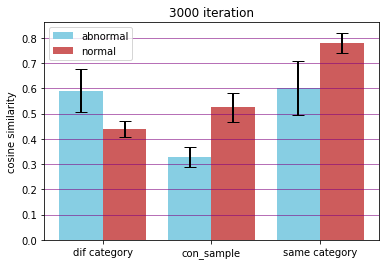

category:  8
0.6179251848448564 0.4829708745379195
0.32655134428792043 0.46718159477036647
0.6417397920541169 0.7722769706992965


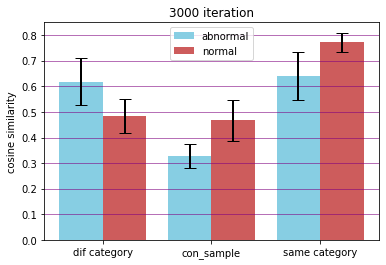

category:  9
0.6124573983517108 0.4498645795142526
0.31827472130813567 0.4977443614490261
0.6458327081703927 0.7523993802112865


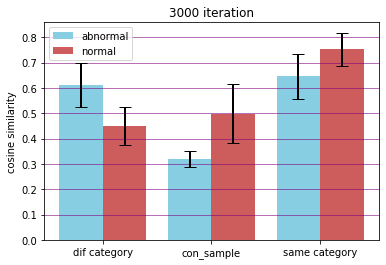

average gradient: 
category:  9
0.6002695991110139 0.46950008171126534
0.32772427155527895 0.46931468709771024
0.6134126182848434 0.7600372510229674


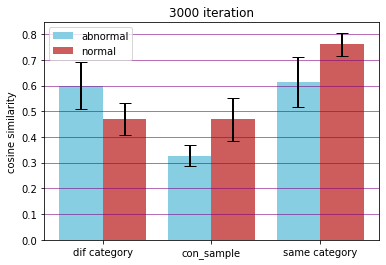

In [ ]:
plot_gradient(fshawd1, slw1, cpriv, 3000)

category:  0
0.7688342124426879 0.47714009151731396
0.6099309685664025 0.43939901452386804
0.7667043235771219 0.7089719783025932


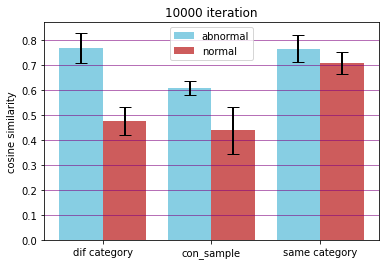

category:  1
0.7730196174112254 0.4746900127202365
0.5851097155258538 0.4284541193498842
0.7891289945565116 0.7116680992356177


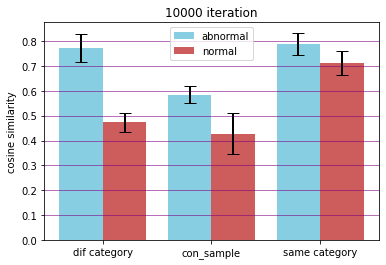

category:  2
0.7738008513306252 0.4452255473005941
0.6127741236308965 0.44751471401355153
0.7880903901079592 0.7117631611110316


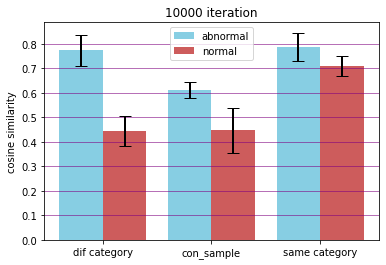

category:  3
0.7943027014544511 0.471330144373583
0.6085702457041665 0.44357672853292734
0.7931866423236082 0.69552432540347


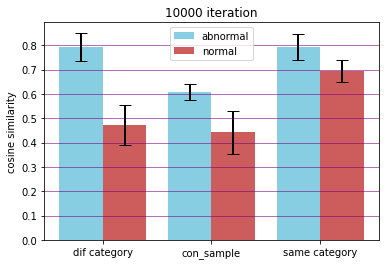

category:  4
0.7786671564460994 0.45885105531775044
0.6114031372725958 0.47677399129049847
0.8091973208145675 0.7148209262455671


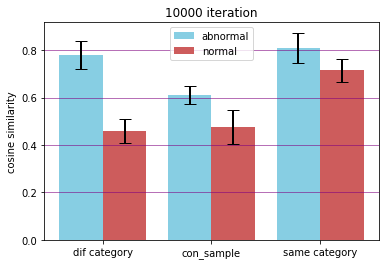

category:  5
0.7789912762298433 0.47823306108502184
0.6119834126607683 0.47293884417953835
0.7931519612246472 0.7084420707845198


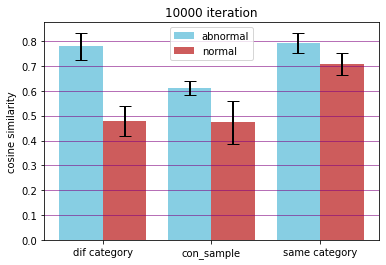

category:  6
0.7967091163689126 0.47288804201752754
0.6079175003320225 0.47839572245882706
0.7991095951202754 0.7254149424232914


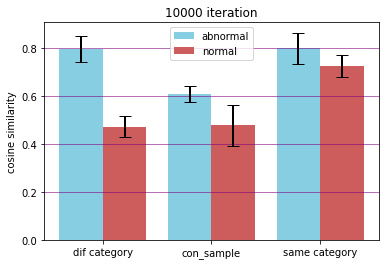

category:  7
0.7505979828473867 0.49351786814655374
0.6071229896327787 0.5042084589840246
0.8004461878928969 0.7419094935935244


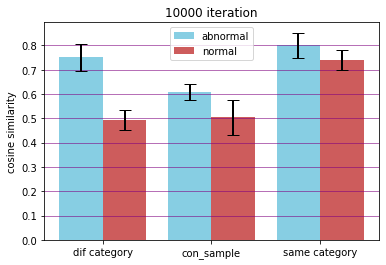

category:  8
0.7906636897202171 0.48742088999506694
0.6091527492351748 0.47105489771327375
0.7896354557378065 0.72060289567965


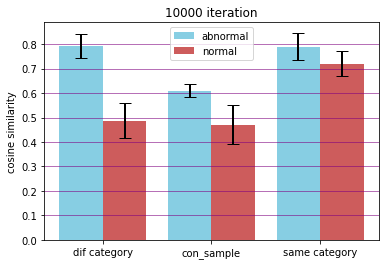

category:  9
0.7728018680170221 0.47370907138431434
0.5814617264374116 0.47452370401919775
0.8104141950623452 0.7209715734260649


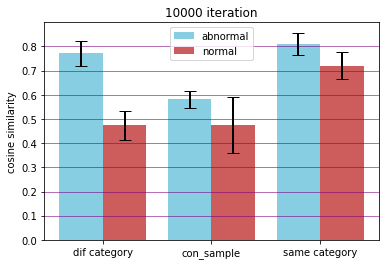

average gradient: 
category:  9
0.7778388472268472 0.4733005783857962
0.6045426568998071 0.46368401950655913
0.793906506641774 0.7160089466205329


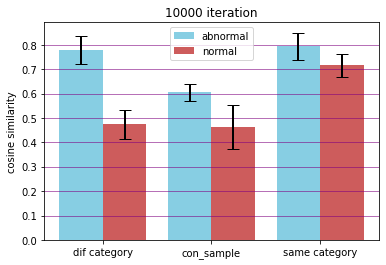

In [ ]:
plot_gradient(fshawd2, slw2, cpriv, 10000)

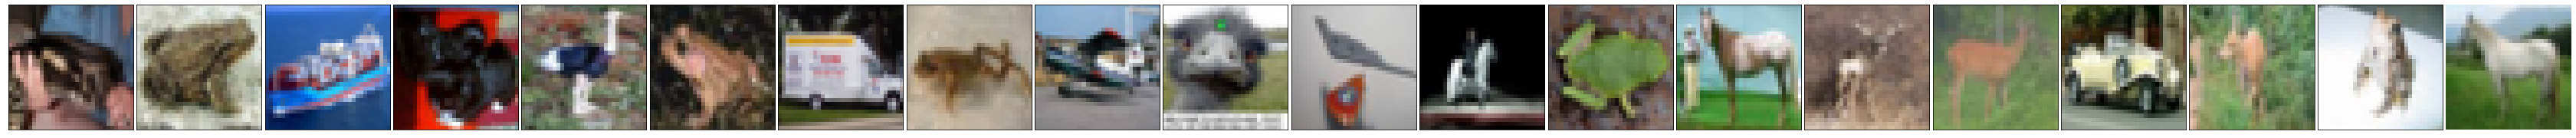

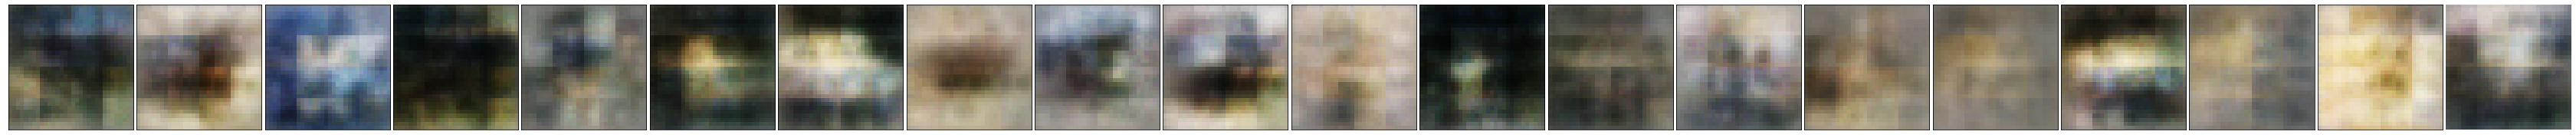

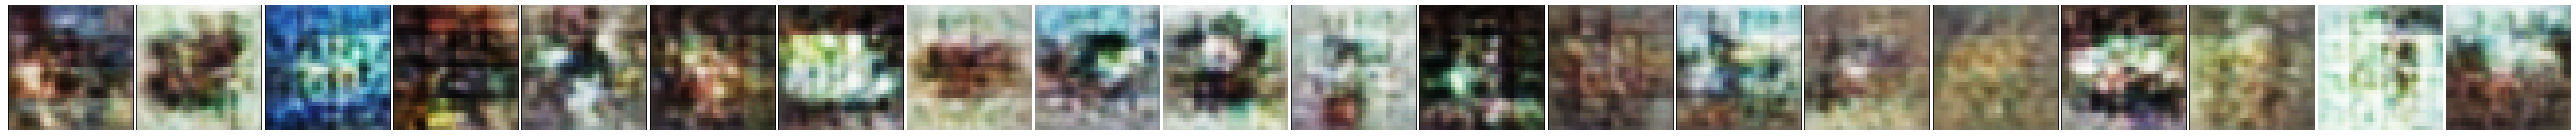

In [ ]:
n = 20
X = getImagesDS(cpriv, n)
X_recovered1, control = fshawd1.attack(X)
X_recovered2, control = fshawd2.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recovered1)
fig = plot(X_recovered2)

In [ ]:
fshawd3 = FSHA_worse(cpriv, cpub, id_setup-1, batch_size, hparams)
fshawd4 = FSHA_worse(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 500
LOG3 = fshawd3(3000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOG4 = fshawd4(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
[4, 6, 3, 5, 4, 13, 8, 8, 5, 8]
log--00%-0000000] validation: 0.2954
[7, 7, 5, 10, 8, 6, 6, 7, 2, 6]
log--16%-0000500] validation: 0.2502
[5, 2, 3, 10, 8, 6, 4, 10, 8, 8]
log--33%-0001000] validation: 0.1216
[4, 6, 8, 4, 9, 8, 7, 5, 5, 8]
log--50%-0001500] validation: 0.0929
[9, 8, 7, 3, 4, 5, 9, 8, 5, 6]
log--66%-0002000] validation: 0.0720
[6, 5, 8, 5, 10, 5, 6, 4, 7, 8]
log--83%-0002500] validation: 0.0627
RUNNING...
[6, 8, 5, 6, 9, 6, 3, 7, 6, 8]
log--00%-0000000] validation: 0.3023
[5, 4, 12, 7, 8, 6, 5, 10, 4, 3]
log--05%-0000500] validation: 0.2091
[12, 12, 2, 5, 4, 5, 9, 5, 6, 4]
log--10%-0001000] validation: 0.1036
[7, 6, 2, 9, 7, 8, 5, 9, 7, 4]
log--15%-0001500] validation: 0.0802
[6, 4, 12, 5, 4, 5, 10, 3, 4, 11]
log--20%-0002000] validation: 0.0691
[6, 7, 4, 7, 9, 4, 13, 5, 3, 6]
log--25%-0002500] vali

category:  0
0.5603882326091315 0.5109241591071826
0.3315528120363538 0.4245036505317976
0.5937913388249934 0.7366937663861857


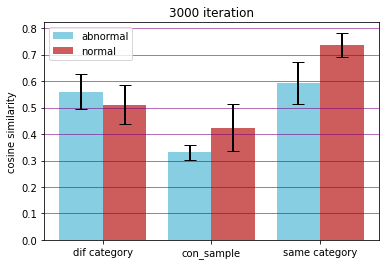

category:  1
0.5839764285535765 0.45543410321375083
0.33702709971430467 0.44388020863299266
0.6044408262916089 0.7748393008926491


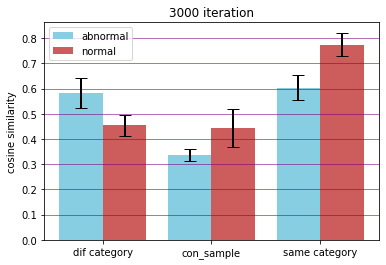

category:  2
0.599286157806729 0.44272934538496994
0.3388950354962169 0.44680077885618674
0.5889356833465869 0.7423189379346955


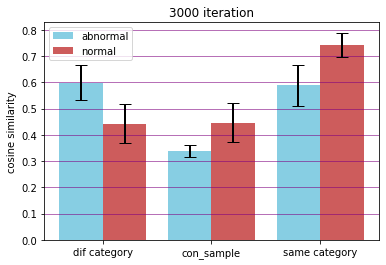

category:  3
0.6024017034499762 0.4720264443891109
0.34099998116597074 0.43503308250740186
0.5928552452319782 0.7440925429594646


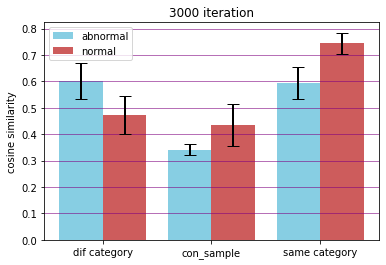

category:  4
0.5879250602989556 0.4580701363764459
0.3460126532558779 0.5132489803189129
0.6267765404597871 0.7710237953649521


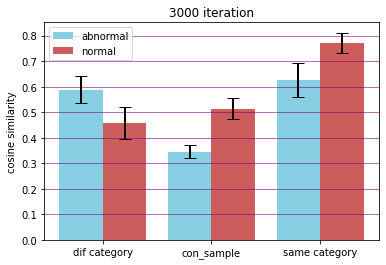

category:  5
0.6131243610476877 0.4976945817148999
0.3377474215732771 0.4577342492408497
0.5965811447342935 0.7539426375347041


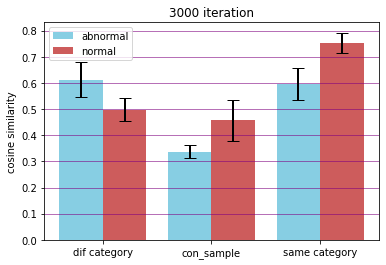

category:  6
0.6164804252285688 0.48460792487601184
0.34654246827358665 0.4830085925652038
0.6365308948587614 0.7757323066041161


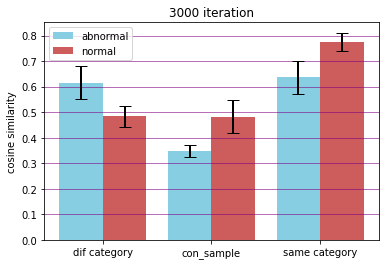

category:  7
0.553527545507954 0.43937702105327237
0.33821574009528055 0.5121596375064186
0.6056625094025032 0.7799053911412446


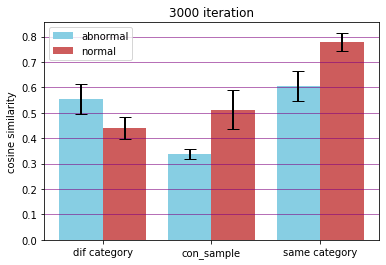

category:  8
0.5709020737081956 0.4892763629966667
0.34221933364464363 0.4637876333011086
0.5835784737229311 0.7742759466079083


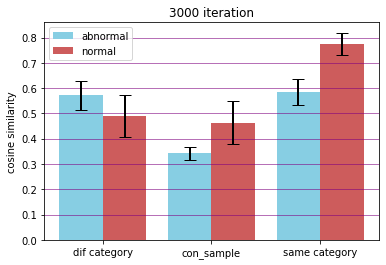

category:  9
0.572402539221353 0.46531746315506495
0.3423422661954072 0.5140206691185312
0.6003064377583056 0.7599617373740893


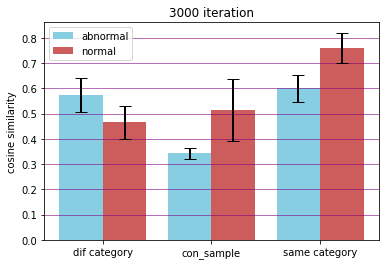

average gradient: 
category:  9
0.5860414527432128 0.47154575422673756
0.3401554811450919 0.46941774825794036
0.6029459094631748 0.7612786362800009


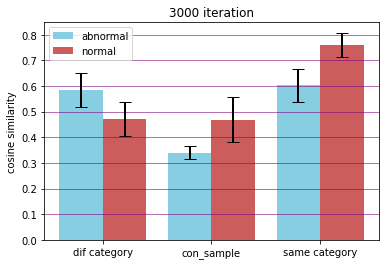

In [ ]:
plot_gradient(fshawd3, slw1, cpriv, 3000)

category:  0
0.5993393616976308 0.48034736444890613
0.35058420377892463 0.4533043298303877
0.599256656683739 0.7099813717018728


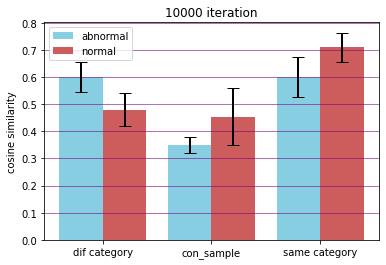

category:  1
0.5988280194880715 0.4650810901401098
0.34346609166066155 0.44219033837695687
0.6102331568067497 0.7274615857957498


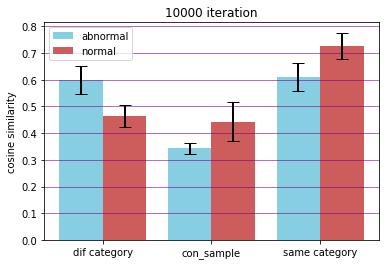

category:  2
0.6066031036254333 0.4527935161657243
0.3646358413472882 0.44246584775594516
0.6063491717912775 0.7173061451117575


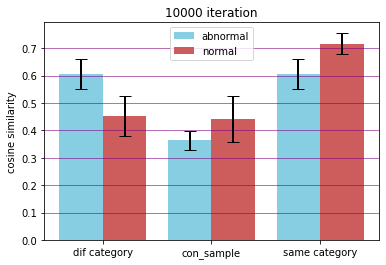

category:  3
0.6162920807723706 0.4849822678024199
0.35402789544604857 0.42684933736868946
0.600430315398963 0.6874748468307907


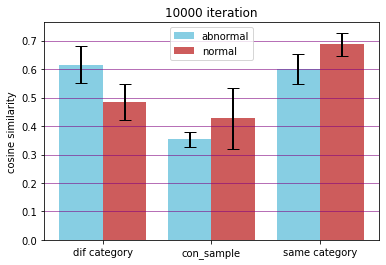

category:  4
0.5971729960997785 0.4572365925408947
0.36713826178262055 0.48843405122286015
0.6104663924821767 0.7152001084923219


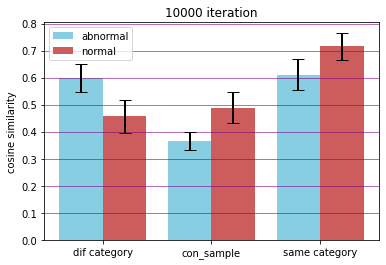

category:  5
0.6050261608721166 0.48205203636851973
0.3526221783253858 0.4544254285507677
0.607994250499422 0.7155145258564819


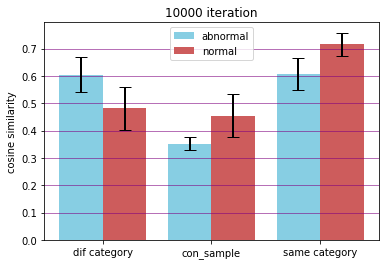

category:  6
0.619402473670408 0.4710253083807261
0.36689943113494305 0.4697273740198317
0.6314491663381869 0.725289108453125


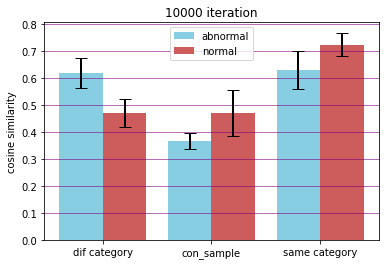

category:  7
0.5978120824779221 0.4857435026777791
0.3447989798390509 0.4978804619206473
0.6275867834984451 0.7461144299824711


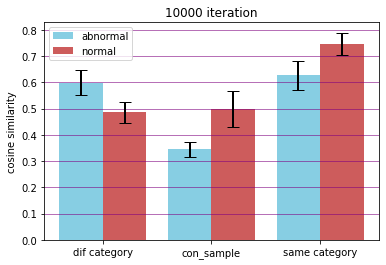

category:  8
0.6106989214933969 0.48855127709066637
0.359067849908271 0.47069619380143235
0.6132732705301864 0.7088412567669597


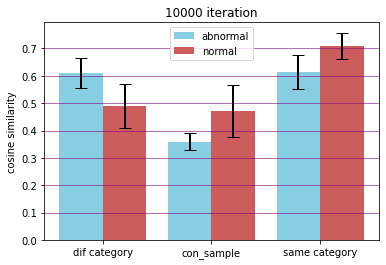

category:  9
0.5999637699534364 0.4850710641359713
0.3481262749981868 0.44361904612546893
0.623684177331137 0.7202460324327529


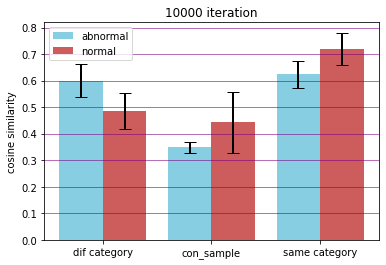

average gradient: 
category:  9
0.6051138970150565 0.47528840197517175
0.3551367008221381 0.4589592408972988
0.6130723341360284 0.7173429411424284


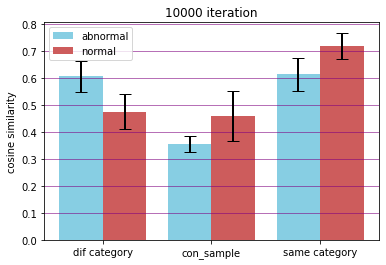

In [ ]:
plot_gradient(fshawd4, slw2, cpriv, 10000)

In [ ]:
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'w' : 10,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}
fshawd5 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
fshawd6 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
fshawd7 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
fshawd8 = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 100
# LOG5 = fshawd5(1000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOG6 = fshawd6(3000, verbose=True, progress_bar=False, log_frequency=log_frequency)
# LOG7 = fshawd5(5000, verbose=True, progress_bar=False, log_frequency=log_frequency)
# LOG8 = fshawd6(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
[56, 66, 65, 68, 71, 57, 61, 76, 70, 50]
log--00%-0000000] validation: 0.2770
[67, 65, 74, 51, 59, 64, 54, 82, 53, 71]
log--03%-0000100] validation: 0.2666
[65, 73, 74, 63, 52, 62, 57, 71, 59, 64]
log--06%-0000200] validation: 0.2556
[76, 63, 63, 62, 65, 61, 71, 67, 54, 58]
log--10%-0000300] validation: 0.2478
[68, 60, 69, 68, 57, 65, 66, 62, 61, 64]
log--13%-0000400] validation: 0.2501
[57, 79, 82, 53, 68, 69, 72, 50, 54, 56]
log--16%-0000500] validation: 0.2534
[59, 66, 62, 77, 57, 68, 68, 57, 78, 48]
log--20%-0000600] validation: 0.2542
[64, 68, 73, 56, 56, 80, 55, 55, 61, 72]
log--23%-0000700] validation: 0.2536
[63, 62, 68, 69, 76, 56, 60, 75, 59, 

In [ ]:
slw3 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
slw4 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
slw5 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
slw6 = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
# LOGs = slw3(1000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOGs = slw4(3000, verbose=True, progress_bar=False, log_frequency=log_frequency)
# LOGs = slw5(5000, verbose=True, progress_bar=False, log_frequency=log_frequency)
# LOGs = slw6(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

category:  0
0.5409080037624243 0.4705962332760084
0.5091968864560084 0.46455008951152865
0.5512240181028865 0.7623053610261834


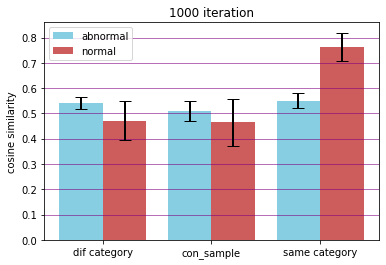

category:  1
0.5366545283375146 0.4664580949646316
0.49635399646758815 0.4488574992350498
0.5407720927449282 0.7980786106205966


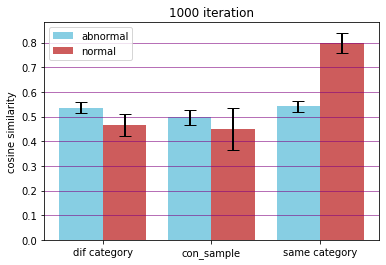

category:  2
0.5354400755433577 0.4383096593682655
0.5059038332528747 0.4469835980741751
0.544682844991697 0.7672869220374391


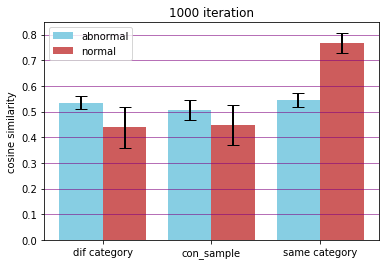

category:  3
0.5458538988982036 0.46849095625102316
0.5104868029639389 0.4642367783222517
0.5399529704478498 0.7511397188187354


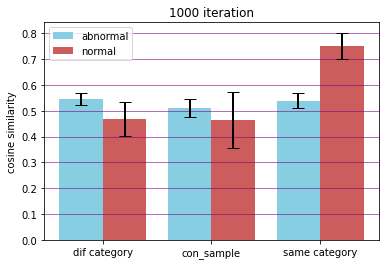

category:  4
0.538833004819355 0.481634990712113
0.5132758568423196 0.517219801393141
0.5484087828286991 0.7697554719829423


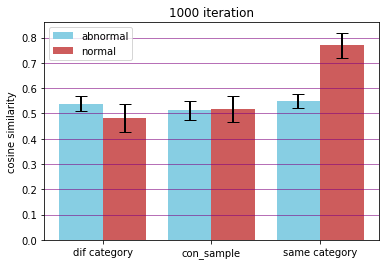

category:  5
0.5452676141275853 0.47696658732494424
0.5061136993034878 0.46547107374150754
0.541636832098146 0.7651331339528236


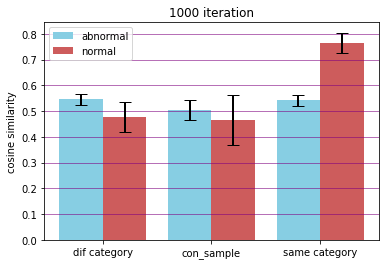

category:  6
0.5383217293940622 0.4424324051388474
0.5087154895611647 0.47891015427196065
0.5528815392690758 0.7972423540707723


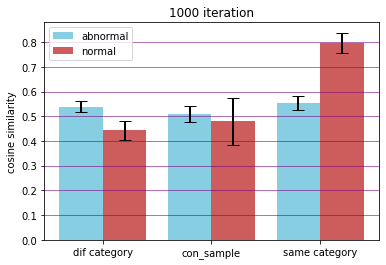

category:  7
0.5425405787315233 0.45786360396197184
0.49226283063988313 0.5004059684916421
0.5395782824879045 0.7999401278627425


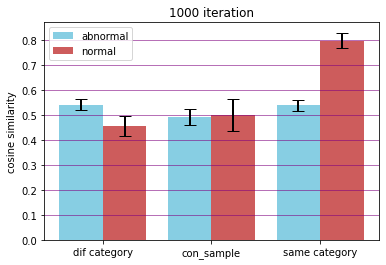

category:  8
0.5450670811235628 0.4687899574464484
0.5123040122238767 0.45537390174052106
0.5493826264678621 0.7798095275605506


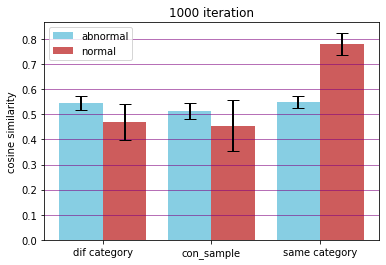

category:  9
0.538895079194194 0.49461142897211224
0.4964725168605587 0.473445771915361
0.5472845597698555 0.7808761057145928


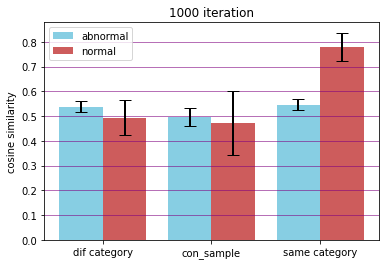

average gradient: 
category:  9
0.5407781593931783 0.46661539174163663
0.5051085924571701 0.4715454636697139
0.5455804549208905 0.7771567333647378


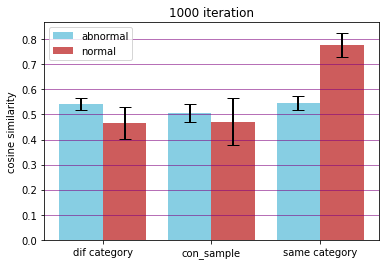

In [ ]:
plot_gradient(fshawd5, slw3, cpriv, 1000)

In [ ]:
plot_gradient(fshawd6, slw4, cpriv, 3000)

In [ ]:
plot_gradient(fshawd7, slw5, cpriv, 5000)

In [ ]:
plot_gradient(fshawd8, slw6, cpriv, 10000)